In [1]:
import pandas as pd
import numpy as np
import random
import graphviz as gr
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

from Helper_function import fn_generate_multnorm,fn_randomize_treatment,fn_bias_rmse_size

# Q1 The First Setting

The specification of the true model is following with one observed covariates:

$y_i = \tau*T_i+\beta'*x_i+e_i$

There are no confounders and $x_i$ represents the observed covariates

The DAG of this setting is following:

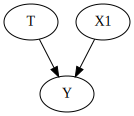

In [2]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X1", "Y")
g

## Step 1 Simulate DGP


In [3]:
### Define a function to simulate data
def fn_generate_data(tau,N,p,beta0,corr = 0.5,conf = True,conx = True,contx = True,contf = True):
    #Inputs
    # -tau: treatment effect parameter
    # -N: Number of observations (Sample size)
    # -P: Number of covariates
    # -beta0: the matrix of true parameters of the observed covariates
    # -corr: Correlation for multivariate normal
    # -conf: Indicating the existence of confounding factors
    # -conx: Indicating the existence of covariates factors
    # -contx: Indicating whether we control the covariates
    # -contf: Indicating whether we control the confoundings


    nvar = p+1 # Add 1 confounder

    if conf == False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1

    if conx == False:
        conx_mult = 0 # remove observed covariates from outcome
    else:
        conx_mult = 1

    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,0].reshape([N,1]) # confounder
    X = allX[:,1:] # observed covariates
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])

    Yab = tau*T+conx_mult*X@beta0+conf_mult*0.6*C+err

    if contx == False:
        X = np.zeros([N,1])

    if contf == False:
        C = np.zeros([N,1])

    return Yab, T, X, C

Assign the values to the true model, with $\tau$ = 2 , $\beta_1$ = 5,
and the sample size will be 100.

$y_i = 2*T_i+5*x_1 +e_i$

In [4]:
np.random.seed(10)
tau = 2
N = 100
p = 1
beta0 = np.array([[5]]).reshape(1,-1)

Y, T, X, C = fn_generate_data(tau,N,p,beta0,corr = 0.5,conf = False,conx = True,contx = True,contf = False)

In [5]:
### Store the simulated data
data_Q1 = np.hstack([Y,T,X,C])
data_Q1 = pd.DataFrame(data_Q1)
data_Q1.columns = ["Y","Treatment","X1","Confounder"]
data_Q1.to_csv("data_Q1.csv")

## Step 2 Monte Carlo Simulation

In [6]:
### Define a function to estimate the treatment effect of random sample using OLS
def fn_estimate_params(Y,T,X,C):
    #Inputs
    # -Y: Outcome value of Dependent Variable
    # -T: Indicating the treatment group 0/1
    # -X: Value of observed covariates
    # -C: Value of Confounders

    covar = np.hstack([T,X,C])
    idx = np.argwhere(np.all(covar[..., :] == 0, axis=0))
    covars = np.delete(covar, idx, axis=1)

    mod = sm.OLS(Y,covars)
    res = mod.fit()
    tauhat = res.params[0]
    se_tauhat = res.HC1_se[0]

    return tauhat,se_tauhat

In [7]:
### Define a function to do the monte carlo simulation
def run_mc_simulation(n_rep,tau,N,p,beta0,corr = 0.5,conf = False,conx = False,contx = True,contf = True):
    #Inputs
    # -n_rep: Number of replication time for monte carlo simulation
    # -tau: treatment effect parameter
    # -N: Number of observations (Sample size)
    # -P: Number of covariates
    # -beta0: the matrix of true parameters of the observed covariates
    # -corr: Correlation for multivariate normal
    # -conf: Indicating the existence of confounding factors
    # -conx: Indicating the existence of covariates factors
    # -contx: Indicating whether we control the covariates
    # -contf: Indicating whether we control the confoundings

    estDict = {}
    for n in N:
        tauhats = []
        sehats = []
        for rep in tqdm(range(n_rep)):
            Y,T,X,C = fn_generate_data(tau,n,p,beta0,corr,conf,conx,contx,contf)
            tauhat,sehat = fn_estimate_params(Y,T,X,C)
            tauhats = tauhats + [tauhat]
            sehats = sehats + [sehat]
        estDict[n] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
        }

    return estDict

In [8]:
### Define a function to summarize the results of monte carlo simulation
def summarize_mc_simulation(tau,n_rep,N,estDict):
    tau0 = tau*np.ones([n_rep,1])
    for N, results in estDict.items():
        (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                             results['sehat'])

        print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')


### Case a:
I do not control the covariates, which means the "contx" will be FALSE


In [18]:
np.random.seed(0)
n_rep = 2000
tau = 2
N = [100,1000]
p = 1
beta0 = np.array([[5]]).reshape(1,-1)

estDict = run_mc_simulation(n_rep,tau,N,p,beta0,corr = 0.5,conf = False,conx = True,contx = False,contf = False)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|██████████| 2000/2000 [00:05<00:00, 398.95it/s]

N=100: bias=1.1698747274078027, RMSE=1.378183213414323, size=0.537
N=1000: bias=1.1707029542979976, RMSE=1.2745009146267867, size=0.934


### Case b:
I control the covariates, which means the "contx" will be TRUE

In [ ]:
np.random.seed(0)
n_rep = 2000
tau = 2
N = [100,1000]
p = 1
beta0 = np.array([[5]]).reshape(1,-1)

estDict = run_mc_simulation(n_rep,tau,N,p,beta0,corr = 0.5,conf = False,conx = True,contx = True,contf = False)
summarize_mc_simulation(tau,n_rep,N,estDict)


 66%|██████▋   | 1329/2000 [00:03<00:01, 414.45it/s]

### Real life example:
Students are randomly assigned to participate into a programme which offers extra tutorial aiming to improve
their study performance. In order to study the effect of this programme (Treatment variable) on the study performance
(Outcome variable), it controls the parents' education (Observed covariates).


# Q2 The Second Setting
The specification of the true model is following with one confounder:

$y_i = \tau*T_i+\beta'*c_i+e_i$

There is one confounder and no other observed covariates.
We assume that $\tau$ = 2, $\beta$ = 0.6, therefore:

$y_i = 2*T_i+0.6*c_i+e_i$

The DAG of this setting is following:

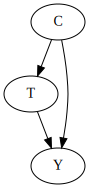

In [11]:
g = gr.Digraph()
g.edge("C", "T")
g.edge("T", "Y")
g.edge("C", "Y")
g

In this setting, the major difference from the first setting is that
the confounder should be generated in a way that is correlated with the treatment.

Therefore, we should modify the function "fn_generate_data", and to make Treatment also affected by Confounders.

The strategy here is to assume treatment is linearly correlated with Confounder, and we use the idea of
logistic regression to calculate the probability of treatment. If it is larger than 0.5, it will be treated.
Otherwise, it will be in the control group.

$T_i = \beta_0+\beta_1*c_i+e_i$



In [12]:
### Define a function to separate the samples to treated and non treated based on confounders
def fn_confounders_treatment(C,N):
    #Inputs
    # -C: Confounders
    # -N: Number of observations (Sample size)

    err = np.random.normal(0,1,[N,1])
    treated = 1 + 2 * C + err
    treated_prob = 1/(1+np.exp(-treated))

    return np.array([(1 if treated_prob[i] >= 0.5 else 0) for i in range(N)]).reshape([N,1])

### Define a function to simulate data
def fn_generate_data(tau,N,p,beta0,corr = 0.5,conf = True,conx = True,contx = True,contf = True):
    #Inputs
    # -tau: treatment effect parameter
    # -N: Number of observations (Sample size)
    # -P: Number of covariates
    # -beta0: the matrix of true parameters of the observed covariates
    # -corr: Correlation for multivariate normal
    # -conf: Indicating the existence of confounding factors
    # -conx: Indicating the existence of covariates factors
    # -contx: Indicating whether we control the covariates
    # -contf: Indicating whether we control the confoundings


    nvar = p+1 # Add 1 confounder

    if conf == False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1

    if conx == False:
        conx_mult = 0 # remove observed covariates from outcome
    else:
        conx_mult = 1

    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,0].reshape([N,1]) # confounder
    X = allX[:,1:] # observed covariates

    T = fn_confounders_treatment(C,N) # choose treated units with the effect of C
    err = np.random.normal(0,1,[N,1])

    Yab = tau*T+conx_mult*X@beta0+conf_mult*0.6*C+err

    if contx == False:
        X = np.zeros([N,1])

    if contf == False:
        C = np.zeros([N,1])

    return Yab, T, X, C

## Step 1 Simulate DGP

In [13]:
np.random.seed(100)
tau = 2
N = 100
p = 1
beta0 = np.array([[5]]).reshape(1,-1)

Y, T, X, C = fn_generate_data(tau,N,p,beta0,corr = 0.5,conf = True,conx = False,contx = False,contf = True)

In [14]:
### Store the simulated data
data_Q2 = np.hstack([Y,T,X,C])
data_Q2 = pd.DataFrame(data_Q2)
data_Q2.columns = ["Y","Treatment","X1","Confounder"]
data_Q2.to_csv("data_Q2.csv")


## Step 2 Monte Carlo Simulation
### Case a:
I do not control the confounders, which means the "contf" will be FALSE

In [15]:
np.random.seed(20)
n_rep = 2000
tau = 2
N = [100,1000]
p = 1
beta0 = np.array([[5]]).reshape(1,-1)

estDict = run_mc_simulation(n_rep,tau,N,p,beta0,corr = 0.5,conf = True,conx = False,contx = False,contf = False)
summarize_mc_simulation(tau,n_rep,N,estDict)

100%|██████████| 2000/2000 [00:05<00:00, 397.14it/s]

N=100: bias=0.2814458355214624, RMSE=0.33137049295230814, size=0.5465
N=1000: bias=0.2804839195593515, RMSE=0.3051698471701159, size=0.944


### Case b:
I control the confounders, which means the "contf" will be TRUE

In [312]:
np.random.seed(20)
n_rep = 2000
tau = 2
N = [100,1000]
p = 1
beta0 = np.array([[5]]).reshape(1,-1)

estDict = run_mc_simulation(n_rep,tau,N,p,beta0,corr = 0.5,conf = True,conx = False,contx = False,contf = True)
summarize_mc_simulation(tau,n_rep,N,estDict)


100%|██████████| 2000/2000 [00:06<00:00, 290.51it/s]

N=100: bias=0.000289415940535101, RMSE=0.13096272489991012, size=0.0525
N=1000: bias=0.0019991305035177314, RMSE=0.042171385297211796, size=0.0525


### Real life example:
If one wants to analyze the effect of smoking (Treatment variable) on the mortality (Outcome Variable),
the interpretation of the difference between groups needs to be cautious. Since the gender is likely to be the confounding
variables.it is known that males are more likely to smoke than females, and males are also more likely
to die young as a result of other general risk-raking behavior. In this case, the higher mortality rate among smokers
has nothing to do with (or at least is not entirely due to) the smoking itself, but rather is to do gender discrepancies
and the differences in risk-taking behaviors afforded by such a discrepancy.

# Q3 The Third Setting
The specification of the true model is following with no confounder and no observed covariates

$y_i = \tau*T_i+e_i$

but there is a mediators between the path from the treatment to the outcome, which is affected by the treatment:

$X_i = \beta_0+\beta_1*T_i+e_i$

Then, the true model can be written as:

$y_i = \tau'*T_i+ \lambda*X_i + e_i$

where $\tau = \tau' + \lambda * \beta_1$

The DAG of this setting is following:

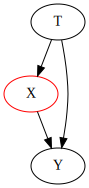

In [326]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("X", "Y")
g.node("X", "X", color="red")
g

Then, let's assume $\tau =2, \tau' = 1.5, \lambda = 0.25, \beta_1 = 2$

In [327]:
### Define a function to simulate data
def fn_generate_selection_data(tau1,N,beta1,lambda_x,conts = False):
    #Inputs
    # -tau: treatment effect parameter
    # -N: Number of observations (Sample size)
    # -conts: Indicating whether we control the mediators(selection bias variable)

    T = fn_randomize_treatment(N) # choose treated units
    err1 = np.random.normal(0,10,[N,1])
    X = 0.5 + beta1*T + err1
    err = np.random.normal(0,1,[N,1])

    Yab = tau1*T+lambda_x*X+err

    if conts == False:
        X = np.zeros([N,1])

    return Yab, T, X

### Define a function to estimate the treatment effect of random sample using OLS
def fn_estimate_params(Y,T,X):
    #Inputs
    # -Y: Outcome value of Dependent Variable
    # -T: Indicating the treatment group 0/1
    # -X: Value of Mediators(selection bias variable)

    covar = np.hstack([T,X])
    idx = np.argwhere(np.all(covar[..., :] == 0, axis=0))
    covars = np.delete(covar, idx, axis=1)

    mod = sm.OLS(Y,covars)
    res = mod.fit()
    tauhat = res.params[0]
    se_tauhat = res.HC1_se[0]

    return tauhat,se_tauhat

### Define a function to do the monte carlo simulation
def run_mc_simulation(n_rep,tau1,N,beta1,lambda_x,conts = False):
    #Inputs
    # -n_rep: Number of replication time for monte carlo simulation
    # -tau: treatment effect parameter
    # -N: Number of observations (Sample size)
    # -conts: Indicating whether we control the mediators(selection bias variable)

    estDict = {}
    for n in N:
        tauhats = []
        sehats = []
        for rep in tqdm(range(n_rep)):
            Y,T,X = fn_generate_selection_data(tau1,n,beta1,lambda_x,conts)
            tauhat,sehat = fn_estimate_params(Y,T,X)
            tauhats = tauhats + [tauhat]
            sehats = sehats + [sehat]
        estDict[n] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
        }

    return estDict

### Define a function to summarize the results of monte carlo simulation
def summarize_mc_simulation(tau1,lambda_x,beta1,n_rep,N,estDict):
    tau0 = (tau1+lambda_x*beta1)*np.ones([n_rep,1])
    for N, results in estDict.items():
        (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                             results['sehat'])

        print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

## Step 1 Simulate DGP

In [328]:
np.random.seed(100)
tau1 = 1.5
lambda_x = 0.25
beta1 = 2
N = 100

#True tau
tau = tau1 + lambda_x*beta1

Y, T, X = fn_generate_selection_data(tau1,N,beta1,lambda_x,conts = False)

In [329]:
### Store the simulated data
data_Q3 = np.hstack([Y,T,X])
data_Q3 = pd.DataFrame(data_Q3)
data_Q3.columns = ["Y","Treatment","Mediators"]
data_Q3.to_csv("data_Q3.csv")


## Step 2 Monte Carlo Simulation
### Case a:
I control the mediators(selection bias variable), which means the "conts" will be True

In [330]:
np.random.seed(10)
np.random.seed(100)
tau1 = 1.5
lambda_x = 0.25
beta1 = 2
N = [100,1000]

#True tau
tau = tau1 + lambda_x*beta1

estDict = run_mc_simulation(n_rep,tau1,N,beta1,lambda_x,conts=True)
summarize_mc_simulation(tau1,lambda_x,beta1,n_rep,N,estDict)

100%|██████████| 2000/2000 [00:14<00:00, 134.06it/s]

N=100: bias=-0.5016565887292146, RMSE=0.523037044433964, size=0.928
N=1000: bias=-0.50138818674844, RMSE=0.5035352156825205, size=1.0


### Case b:
I do not control the mediators(selection bias variable), which means the "conts" will be False

In [331]:
np.random.seed(10)
np.random.seed(100)
tau1 = 1.5
lambda_x = 0.25
beta1 = 2
N = [100,1000]

#True tau
tau = tau1 + lambda_x*beta1

estDict = run_mc_simulation(n_rep,tau1,N,beta1,lambda_x,conts=False)
summarize_mc_simulation(tau1,lambda_x,beta1,n_rep,N,estDict)

100%|██████████| 2000/2000 [00:13<00:00, 144.14it/s]

N=100: bias=0.13722903094455685, RMSE=0.411879232912311, size=0.0795
N=1000: bias=0.12385841614261445, RMSE=0.1740604085395366, size=0.1875


### Real life example
In the study of the effect of education (Treatment variable) on the income level (Outcome variable), there is likely to be
a mediator such as white collar job (selection bias variable), which exists between the path from the treatment to the outcome.
More educated people are more likely to have higher wage, and also more likely to be a white collar, and then the white collar
will lead to a higher wage. Thus, if conditioning on the white collar variable, we would biase the causal effect estimation since
it closes one of the channels through which the treatment operates, and it will induce a negative bias.